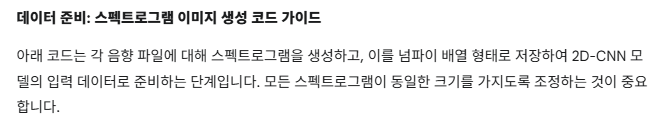

100/6480 파일 처리 완료.
200/6480 파일 처리 완료.
300/6480 파일 처리 완료.
400/6480 파일 처리 완료.
500/6480 파일 처리 완료.
600/6480 파일 처리 완료.
700/6480 파일 처리 완료.
800/6480 파일 처리 완료.
900/6480 파일 처리 완료.
1000/6480 파일 처리 완료.
1100/6480 파일 처리 완료.
1200/6480 파일 처리 완료.
1300/6480 파일 처리 완료.
1400/6480 파일 처리 완료.
1500/6480 파일 처리 완료.
1600/6480 파일 처리 완료.
1700/6480 파일 처리 완료.
1800/6480 파일 처리 완료.
1900/6480 파일 처리 완료.
2000/6480 파일 처리 완료.
2100/6480 파일 처리 완료.
2200/6480 파일 처리 완료.
2300/6480 파일 처리 완료.
2400/6480 파일 처리 완료.
2500/6480 파일 처리 완료.
2600/6480 파일 처리 완료.
2700/6480 파일 처리 완료.
2800/6480 파일 처리 완료.
2900/6480 파일 처리 완료.
3000/6480 파일 처리 완료.
3100/6480 파일 처리 완료.
3200/6480 파일 처리 완료.
3300/6480 파일 처리 완료.
3400/6480 파일 처리 완료.
3500/6480 파일 처리 완료.
3600/6480 파일 처리 완료.
3700/6480 파일 처리 완료.
3800/6480 파일 처리 완료.
3900/6480 파일 처리 완료.
4000/6480 파일 처리 완료.
4100/6480 파일 처리 완료.
4200/6480 파일 처리 완료.
4300/6480 파일 처리 완료.
4400/6480 파일 처리 완료.
4500/6480 파일 처리 완료.
4600/6480 파일 처리 완료.
4700/6480 파일 처리 완료.
4800/6480 파일 처리 완료.
4900/6480 파일 처리 완료.
5000/6480 파일 처리 완료.
5100/6480

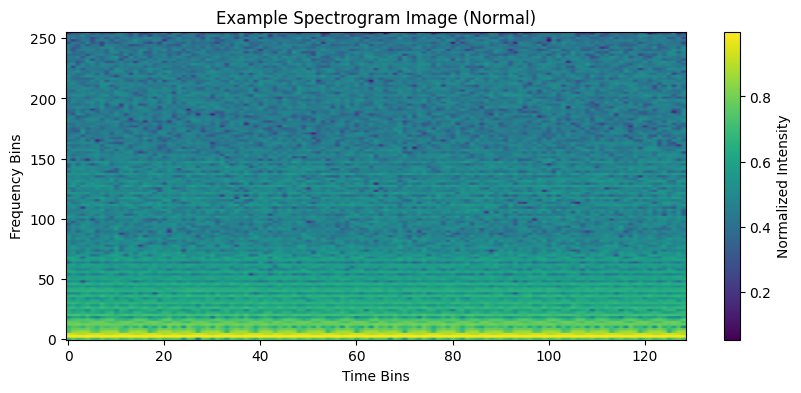


스펙트로그램 이미지 데이터셋 준비 완료.
이제 이 데이터를 사용하여 2D-CNN 모델을 학습시킬 수 있습니다.


In [2]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
from scipy.signal import spectrogram # spectrogram 함수 사용
import cv2 # 이미지 리사이징에 사용 (pip install opencv-python)

# --- 1. 설정 변수 (MMFCC 추출과 동일) ---
# ⚠️ 중요: 이 BASE_PATH를 사용하시는 실제 데이터셋 경로로 설정해주세요.
BASE_PATH = r"C:\Users\jh\Documents\GitHub\BearingGuardian\Dataset"
SAMPLING_RATE = 10000  # Hz
# 스펙트로그램 파라미터 (이전 EDA에서 시도했던 값들 중 하나 선택)
N_PER_SEG = 256        # FFT 윈도우 길이 (샘플 수)
N_OVERLAP = 128        # 오버랩되는 샘플 수 (N_PER_SEG의 50%)
F_MAX_SPEC = SAMPLING_RATE / 2 # 스펙트로그램의 최대 주파수 (나이퀴스트 주파수)

# 모든 스펙트로그램을 동일한 크기로 맞추기 위한 목표 크기
# N_PER_SEG와 N_OVERLAP에 따라 생성되는 주파수 빈(frequency bins) 수가 결정됨
# 이 값은 실제 생성되는 스펙트로그램의 '높이'가 됩니다.
# time bins (너비)는 오디오 길이(10초)와 HOP_LENGTH에 따라 결정되므로,
# 스펙트로그램을 생성한 후, 모두 동일한 크기로 리사이징할 필요가 있습니다.
SPEC_HEIGHT = N_PER_SEG // 2 + 1 # 주파수 빈의 개수 (스펙트로그램 이미지의 높이)
SPEC_WIDTH = 256 # 목표 이미지 너비 (시간 축. 임의의 값으로 설정. 나중에 최적화 가능)

# --- 2. 파일 경로 및 레이블 수집 ---
file_data = [] # (filepath, label) 튜플 저장
class_names = ['Normal', 'Inner Race Fault', 'Outer Race Fault']

for class_name in class_names:
    class_path = os.path.join(BASE_PATH, class_name)
    for filename in sorted(os.listdir(class_path)):
        if filename.endswith('.csv'):
            full_path = os.path.join(class_path, filename)
            file_data.append((full_path, class_name))

# --- 3. 스펙트로그램 생성 및 이미지화 함수 정의 ---
def create_spectrogram_image(file_path, sr, n_per_seg, n_overlap, target_size=(SPEC_WIDTH, SPEC_HEIGHT)):
    try:
        signal = pd.read_csv(file_path).iloc[:, 0].values # 첫 번째 컬럼만 사용
        
        # 스펙트로그램 계산
        # f: 주파수 배열, t: 시간 배열, Sxx: 파워 스펙트로그램
        f, t, Sxx = spectrogram(signal, fs=sr, nperseg=n_per_seg, noverlap=n_overlap)
        
        # 파워 스펙트로그램을 dB 스케일로 변환
        Sxx_db = 10 * np.log10(Sxx + np.finfo(float).eps) # log(0) 방지

        # 스펙트로그램을 0-1 범위로 정규화 (최소-최대 스케일링)
        Sxx_db_min = Sxx_db.min()
        Sxx_db_max = Sxx_db.max()
        Sxx_normalized = (Sxx_db - Sxx_db_min) / (Sxx_db_max - Sxx_db_min)
        
        # 이미지 크기 조정 (height=주파수 빈 수, width=시간 프레임 수)
        # Sxx_normalized.shape = (frequency_bins, time_frames)
        # target_size는 (width, height) 이므로, Sxx_normalized.T를 먼저 해야 함.
        # cv2.resize는 (width, height) 순서로 target_size를 받음
        
        # 현재 스펙트로그램의 실제 시간 프레임 수 (너비)를 확인
        current_spec_width = Sxx_normalized.shape[1]
        current_spec_height = Sxx_normalized.shape[0]

        if current_spec_width == 0: # 신호가 너무 짧아 스펙트로그램 생성 불가 시
            print(f"경고: 파일 {file_path}의 스펙트로그램 너비가 0입니다. 건너뜁니다.")
            return None

        # 리사이징. Interpolation method: INTER_AREA (축소 시 선호) 또는 INTER_LINEAR (일반적)
        # Sxx_normalized는 (freq_bins, time_frames) 형태이므로, resize에 (time_frames, freq_bins)로 전달
        resized_spec = cv2.resize(Sxx_normalized.T, target_size, interpolation=cv2.INTER_AREA)
        
        # 다시 (height, width) 형태로 transpose (선택 사항, Keras Conv2D 입력은 (H, W, C))
        # resized_spec.T의 형태는 (target_size[1], target_size[0]) 즉 (SPEC_HEIGHT, SPEC_WIDTH)
        return resized_spec.T

    except Exception as e:
        print(f"오류 발생 - 파일: {file_path}, 오류: {e}")
        return None

# --- 4. 모든 파일에 대해 스펙트로그램 이미지 생성 ---
X_spectrogram_images = []
y_labels = []
processed_count = 0

for full_path, label in file_data:
    spec_image = create_spectrogram_image(full_path, SAMPLING_RATE, N_PER_SEG, N_OVERLAP, target_size=(SPEC_WIDTH, SPEC_HEIGHT))
    if spec_image is not None:
        # Keras Conv2D 입력은 (samples, height, width, channels) 형태이므로, 채널 차원 추가
        X_spectrogram_images.append(spec_image[:, :, np.newaxis]) # 흑백 이미지이므로 채널 1
        y_labels.append(label)
    
    processed_count += 1
    if processed_count % 100 == 0:
        print(f"{processed_count}/{len(file_data)} 파일 처리 완료.")

print(f"\n--- 스펙트로그램 이미지 생성 완료 ---")
X_spectrogram_images = np.array(X_spectrogram_images)
y_labels = np.array(y_labels)

print(f"생성된 스펙트로그램 이미지 데이터 형태: {X_spectrogram_images.shape}") # (샘플 수, SPEC_HEIGHT, SPEC_WIDTH, 1)
print(f"생성된 레이블 데이터 형태: {y_labels.shape}")

# --- 5. (선택 사항) 생성된 스펙트로그램 이미지 예시 시각화 ---
if len(X_spectrogram_images) > 0:
    plt.figure(figsize=(10, 4))
    plt.imshow(X_spectrogram_images[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Normalized Intensity')
    plt.title(f"Example Spectrogram Image ({y_labels[0]})")
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.show()

print("\n스펙트로그램 이미지 데이터셋 준비 완료.")
print("이제 이 데이터를 사용하여 2D-CNN 모델을 학습시킬 수 있습니다.")


2D-CNN 모델학습

In [4]:
import tensorflow as tf

# GPU 장치 목록 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", tf.config.list_physical_devices('GPU'))

# 특정 장치에서 실행되는지 확인 (선택 사항)
# with tf.device('/GPU:0'):
#     a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
#     b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
#     c = tf.matmul(a, b)
#     print(c)

Num GPUs Available:  0
GPUs:  []


--- GPU 사용 가능 여부 확인 ---
GPU를 찾을 수 없습니다. CPU로 학습을 진행합니다.
2D-CNN 학습 세트 X 형태: (5184, 256, 129, 1)
2D-CNN 테스트 세트 X 형태: (1296, 256, 129, 1)
2D-CNN 학습 세트 y 형태: (5184, 3)
2D-CNN 테스트 세트 y 형태: (1296, 3)

--- 2D-CNN 모델 요약 ---


c:\Users\jh\.conda\envs\br2\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 127, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 62, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 119040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    15,237,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,256,451 (58.20 MB)

 Trainable params: 15,256,451 (58.20 MB)

 Non-trainable params: 0 (0.00 B)


--- 2D-CNN 모델 학습 시작 (GPU 가속 및 조기 종료) ---
Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 27s 179ms/step - accuracy: 0.3366 - loss: 2.0287 - val_accuracy: 0.3276 - val_loss: 1.0987
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.3275 - loss: 1.0987 - val_accuracy: 0.3237 - val_loss: 1.0987
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step - accuracy: 0.3241 - loss: 1.0987 - val_accuracy: 0.3276 - val_loss: 1.0988
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - accuracy: 0.3273 - loss: 1.0987 - val_accuracy: 0.3237 - val_loss: 1.0988
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 26s 177ms/step - accuracy: 0.3327 - loss: 1.0987 - val_accuracy: 0.3237 - val_loss: 1.0987
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.3287 - loss: 1.0987 - val_accuracy: 0.3276 - val_loss: 1.0987
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - accuracy: 0.3346 - loss: 1.0986 - val_accuracy: 0.3276 - val_loss: 1.0987
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2

c:\Users\jh\.conda\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jh\.conda\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jh\.conda\envs\br2\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jh\.conda\

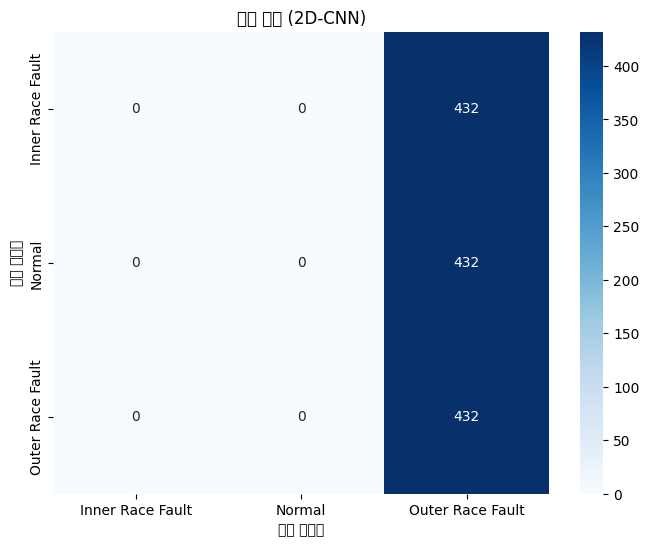

C:\Users\jh\AppData\Local\Temp\ipykernel_300\2404214191.py:149: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  plt.tight_layout()
C:\Users\jh\AppData\Local\Temp\ipykernel_300\2404214191.py:149: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from current font.
  plt.tight_layout()
C:\Users\jh\AppData\Local\Temp\ipykernel_300\2404214191.py:149: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from current font.
  plt.tight_layout()
C:\Users\jh\AppData\Local\Temp\ipykernel_300\2404214191.py:149: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  plt.tight_layout()
C:\Users\jh\AppData\Local\Temp\ipykernel_300\2404214191.py:149: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from current font.
  plt.tight_layout()
C:\Users\jh\AppData\Local\Temp\ipykernel_300\2404214191.py:149: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
C:\Users\jh\AppD

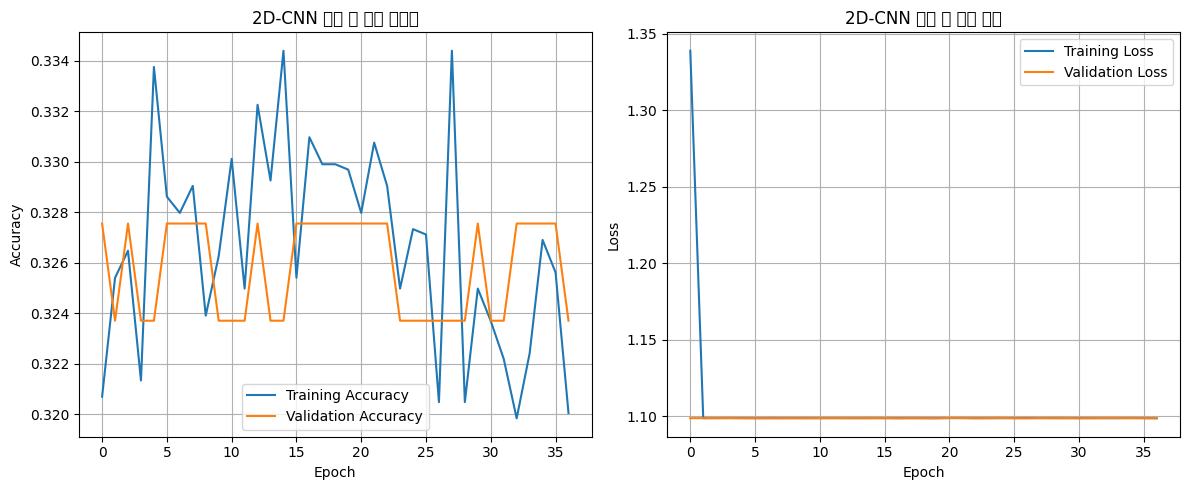


2D-CNN 모델 학습 및 평가가 완료되었습니다.
MMFCC 기반 1D-CNN 및 SVM 결과와 비교하여 성능을 평가할 수 있습니다.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf # TensorFlow 임포트
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping 콜백 임포트
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 0. GPU 사용 가능 여부 확인 및 설정 ---
print("--- GPU 사용 가능 여부 확인 ---")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 특정 GPU에 메모리 증가를 허용하거나, GPU 사용량을 제한할 수 있습니다.
        # for gpu in gpus:
        #     tf.config.experimental.set_memory_growth(gpu, True)
        print(f"사용 가능한 GPU: {len(gpus)}개")
        for gpu in gpus:
            print(f"  {gpu}")
        tf.config.set_visible_devices(gpus, 'GPU') # 모든 GPU 사용
    except RuntimeError as e:
        print(e)
else:
    print("GPU를 찾을 수 없습니다. CPU로 학습을 진행합니다.")

# --- 스펙트로그램 이미지 데이터 (X_spectrogram_images)와 레이블 (y_labels)이 생성되었다고 가정 ---
# (이전 스펙트로그램 이미지 생성 코드를 실행하여 X_spectrogram_images와 y_labels를 먼저 생성해야 합니다.)

# --- 1. 데이터 준비 ---
X = X_spectrogram_images # 스펙트로그램 이미지 배열
y = y_labels # 문자열 레이블 배열

# 레이블 인코딩 (문자열 레이블을 숫자로 변환)
label_encoder_2dcnn = LabelEncoder()
y_encoded_2dcnn = label_encoder_2dcnn.fit_transform(y)
# One-hot 인코딩 (다중 클래스 분류를 위해)
y_onehot_2dcnn = to_categorical(y_encoded_2dcnn)

# 학습 세트와 테스트 세트 분할
X_train_2dcnn, X_test_2dcnn, y_train_2dcnn, y_test_2dcnn = train_test_split(
    X, y_onehot_2dcnn, test_size=0.2, random_state=42, stratify=y_encoded_2dcnn
)

print(f"2D-CNN 학습 세트 X 형태: {X_train_2dcnn.shape}")
print(f"2D-CNN 테스트 세트 X 형태: {X_test_2dcnn.shape}")
print(f"2D-CNN 학습 세트 y 형태: {y_train_2dcnn.shape}")
print(f"2D-CNN 테스트 세트 y 형태: {y_test_2dcnn.shape}")

# --- 2. 2D-CNN 모델 정의 ---
num_classes_2dcnn = y_onehot_2dcnn.shape[1] # 클래스 개수 (Normal, IR, OR)
input_shape_2dcnn = X_train_2dcnn.shape[1:] # (SPEC_HEIGHT, SPEC_WIDTH, 1)

model_2dcnn = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape_2dcnn),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes_2dcnn, activation='softmax')
])

model_2dcnn.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print("\n--- 2D-CNN 모델 요약 ---")
model_2dcnn.summary()

# --- 3. 모델 학습 (조기 종료 로직 추가) ---
print("\n--- 2D-CNN 모델 학습 시작 (GPU 가속 및 조기 종료) ---")

# 조기 종료 콜백 설정
# patience: 검증 손실이 개선되지 않아도 기다릴 에포크 수
# restore_best_weights: 최적의 검증 손실을 보인 에포크의 가중치로 복원
early_stopping_callback = EarlyStopping(
    monitor='val_loss', # 검증 손실을 모니터링
    patience=10,        # 10 에포크 동안 개선 없으면 중지
    restore_best_weights=True,
    verbose=1
)

history_2dcnn = model_2dcnn.fit(X_train_2dcnn, y_train_2dcnn,
                                epochs=50, # 최대 에포크 수
                                batch_size=32,
                                validation_split=0.1, # 학습 데이터의 10%를 검증에 사용
                                callbacks=[early_stopping_callback], # 콜백 리스트에 추가
                                verbose=1)

print("2D-CNN 모델 학습 완료.")

# --- 4. 모델 평가 ---
print("\n--- 2D-CNN 모델 평가 ---")

loss_2dcnn, accuracy_2dcnn = model_2dcnn.evaluate(X_test_2dcnn, y_test_2dcnn, verbose=0)
print(f"테스트 세트 정확도: {accuracy_2dcnn:.4f}")

y_pred_probs_2dcnn = model_2dcnn.predict(X_test_2dcnn)
y_pred_2dcnn_encoded = np.argmax(y_pred_probs_2dcnn, axis=1)
y_true_2dcnn_encoded = np.argmax(y_test_2dcnn, axis=1)

y_pred_2dcnn_labels = label_encoder_2dcnn.inverse_transform(y_pred_2dcnn_encoded)
y_true_2dcnn_labels = label_encoder_2dcnn.inverse_transform(y_true_2dcnn_encoded)

print("\n분류 보고서:")
print(classification_report(y_true_2dcnn_labels, y_pred_2dcnn_labels, target_names=label_encoder_2dcnn.classes_))

conf_matrix_2dcnn = confusion_matrix(y_true_2dcnn_labels, y_pred_2dcnn_labels, labels=label_encoder_2dcnn.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2dcnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder_2dcnn.classes_, yticklabels=label_encoder_2dcnn.classes_)
plt.xlabel('예측 레이블')
plt.ylabel('실제 레이블')
plt.title('혼동 행렬 (2D-CNN)')
plt.show()

# 학습 과정 시각화 (손실 및 정확도)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2dcnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_2dcnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('2D-CNN 학습 및 검증 정확도')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_2dcnn.history['loss'], label='Training Loss')
plt.plot(history_2dcnn.history['val_loss'], label='Validation Loss')
plt.title('2D-CNN 학습 및 검증 손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n2D-CNN 모델 학습 및 평가가 완료되었습니다.")
print("MMFCC 기반 1D-CNN 및 SVM 결과와 비교하여 성능을 평가할 수 있습니다.")


In [7]:
import tensorflow as tf
import os

# 모델 저장 경로 설정
# 현재 프로젝트 구조와 사용자 환경을 고려하여 경로를 설정합니다.
# 예시: C:\Users\jh\Documents\GitHub\BearingGuardian\models_2dcnn
save_dir = r"C:\Users\jh\Documents\GitHub\BearingGuardian\models_2dcnn" 
os.makedirs(save_dir, exist_ok=True) # 폴더가 없으면 생성

model_name = '2d_cnn_spectrogram_perfect_accuracy.h5' # 저장될 모델 파일명
save_path = os.path.join(save_dir, model_name)

# 모델 저장
try:
    model_2dcnn.save(save_path) # model_2dcnn은 이전에 학습된 모델 객체입니다.
    print(f"2D-CNN 모델이 성공적으로 '{save_path}'에 저장되었습니다.")
except Exception as e:
    print(f"2D-CNN 모델 저장 중 오류가 발생했습니다: {e}")

# 저장된 모델 로드 예시 (나중에 모델을 다시 불러올 때 사용)
# loaded_model = tf.keras.models.load_model(save_path)
# print(f"모델이 '{save_path}'에서 성공적으로 로드되었습니다.")


2D-CNN 모델이 성공적으로 'C:\Users\jh\Documents\GitHub\BearingGuardian\models_2dcnn\2d_cnn_spectrogram_perfect_accuracy.h5'에 저장되었습니다.
